# DNA structure generator

Thor van Heesch (T.vanHeesch@uva.nl) & Jocelyne Vreede (J.Vreede@uva.nl), van 't Hoff Institute for Molecular Sciences, University of Amsterdam, May 2024

This tutorial lets you generate linear DNA, curved DNA and knotted DNA. The code in this tutorial is based on `pyMDNA`, using rigid body representations for base pairs, publication in preparation. 

To go through the tutorial, run each cell with code, using either shift-enter or the play button.  

Start with importing relevant libraries. 


In [1]:
#import libraries
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

import pymdna as mdna 

joblib is not installed. Falling back to sequential computation.


### Linear DNA

The `sequence_to_pdb()` function can generate a 3D DNA structure and takes the nucleotide sequence as input:

In [84]:
sequence='CGCGAATTCGCG'
traj = mdna.sequence_to_pdb(sequence)

Sequence: CGCGAATTCGCG
Number of base pairs: 12


Visualize the DNA structure. Try out ribbon and atom (=licorice or spacefill) representation by uncommenting and commenting out code in the cell below. Each time the code is changed, run the cell again to update the visualization. 

Documentation on NGLview: https://nglviewer.org/ngl/api/manual/molecular-representations.html

In [85]:
view = nv.show_mdtraj(traj)
view.add_cartoon()
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

Make DNA of length 12, 21 and 42 basepairs. Notice the number of complete turns. 

### Curved DNA

To construct curved DNA, we use a parametric function in three dimensions, defined by three functions, one for each dimension (x, y, z), depending on one or more parameters. Let's define a spiral parametric function depending on a single parameter `t`:

In [86]:
def parametric_spiral(t, radius=5):
    x = np.cos(t)*radius
    y = np.sin(t)*radius
    z = t  # Linear increment for simplicity
    return x, y, z

Now, generate a range of values for `t`, from 0 to 3π with 100 points. For each value of `t`, `x`, `y`, and `z` coordinates are computed using the parametric function: 

In [87]:
t = np.linspace(0, 3 * np.pi, 100)
x, y, z = parametric_spiral(t)

Plot the three dimensional spiral curve:

Text(0.5, 0.92, '3D Parametric Curve')

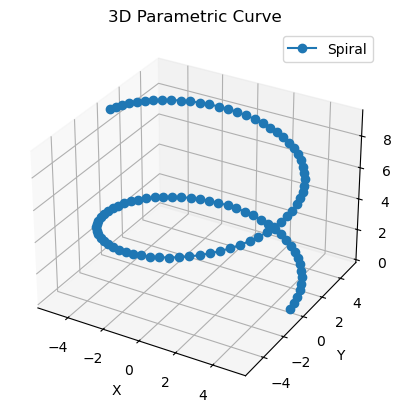

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'o-', label='Spiral')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Parametric Curve')

Now we can use the the x,y,z coordinates to define control points to construct a spline. A spline is a mathematical function used to create smooth curves. It is a type of piecewise polynomial function that is very versatile due to its parametric nature.

In [97]:
control_points = np.array([x, y, z]).T  # Create a (n_points, 3) array
spline = mdna.SplineFrames(control_points)

Now visualize the spline in three dimensions. Notice that each point has an orthonormal basis, the rigid body reference frame for each basepair. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


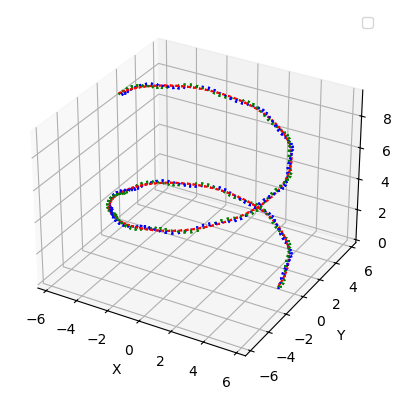

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [98]:
spline.plot_frames(equal=True)

 These reference frames provide a position and mapping to construct the positions of atoms in DNA base pairs. In the following code, atomic positions are generated using the reference frames. The sequence is randomized, unless a sequence is provided. Note that for a predefined sequence, the number of base pairs must match the number of reference frames. 

In [99]:
sequence = None # Make sure if you create your own sequence, it has the same length as the number of base pairs n_bp 
generator = mdna.StructureGenerator(spline)

n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
traj = generator.traj
traj

CCCGATGACCGTGAAGACCCGAATCCTGTACAGTCGTAAGCACTATTCTTCGTCCGCATCAGGATCAACAACCATCCGTCGAATCGCGTGCACGGGGAGGAATCGATCACCCTAATGATGTATGCAGTACACTTGTAGGGTA
Number of base pairs is 142 that fit along the spline.


<mdtraj.Trajectory with 1 frames, 5822 atoms, 284 residues, without unitcells at 0x32c5b76d0>

Next, we can view the structure:

In [100]:
view = nv.show_mdtraj(traj)
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

## Knotted DNA

Generate a DNA structure that is shaped in the form of a knot of your choosing! 

To do so you need to define the knot as a paramatric function. Below the parametric functions of the trefoil knot and the figure-eight knot are provided. You can add a new cell with the parametric function of other knots. 

In [57]:
def parametric_trefoil(t, radius=1):
    x = radius*(np.sin(t)) + radius*(2*np.sin(2*t)) 
    y = radius*(np.cos(t)) - radius*(2*np.cos(2*t))
    z = radius*(-np.sin(3*t))
    return x, y, z

In [131]:
def parametric_figure_eight(t, radius=10):
    x = radius*(2 + np.cos(2*t)*np.cos(3*t))
    y = radius*(2 + np.cos(2*t)*np.sin(3*t))
    z = radius*np.sin(4*t)
    return x, y, z

In [132]:
t = np.linspace(0, 3 * np.pi, 100)  # 0 to 3π with 100 points
#x, y, z = parametric_trefoil(t)
x, y, z = parametric_figure_eight(t)
control_points = np.array([x, y, z]).T  # Create a (n_points, 3) array
spline = mdna.SplineFrames(control_points)

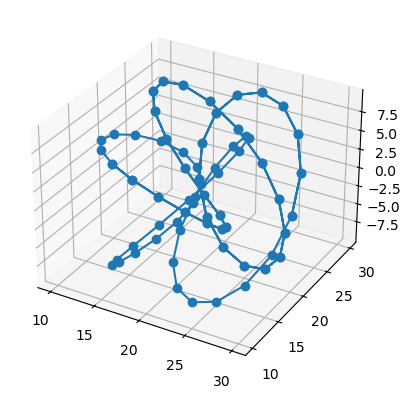

In [133]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')

Number of base pairs is 517 that fit along the spline.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


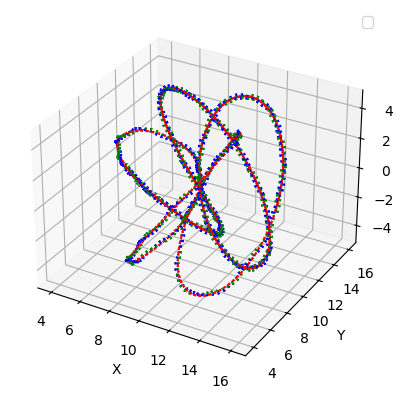

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [127]:
spline = mdna.SplineFrames(control_points)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)

In [134]:
dna = mdna.StructureGenerator(spline,sequence=sequence)
traj = dna.traj
traj

TGGGCCCATAAGCTTGTCAGGCAATTGAGACAGCATCTAGCCAAAGCAAATGCCCAGTTTGCTAGCTCGCTAAGTCAGCAAGGTGATGTAGACGGAGTCTAGGAGGATCAACAGCTGAATATCCCCAATTTCTTAGTCGCATCGTAATCGTATGGTTGGAACGCCCCCCTAGGACTATGCTAGGAGCAGCCTACACGGATTCCCCGATAATTGAGTATATTGGTCTTTTCTGCCCGCATGTCCCCGCCTGGGTCTCCGAATATGCAGGCCAGACTTTACTATCGCTCTCCCGCCTTGGAGACGAGTCACCGTGCGCAAAATCGCTTATAACGTCTATGCGTAACTATCTTTGAGCCCCGTGCTTTCAGTCGCTAGACTTTTCTAGTTAATTCTTTACGGGTTTCAAAGAAGGGCGAGTTATCTGGCTCAGACAGAATGTAACCAGAGGTATCGGTTGCAAGGTGCGCATTTTAATGCCGTCGTGCTGACGTAGGACCCGGTTAGCGTACCCTACCACTACCCTAAGGGAAAGATGTTCAATGCTTACCTAATTGAGAAAAAGGTAGCTAAACTGGAGACAACAGAGAGCGTACAAGCCCTCCACAAATGATAGCTACCGCCGAGCGTTCTAATGACGTTCACTATTAGTATTACCCAGACCACGTCGAACCCGCGCGCAAAGTCCCACTGATTACCTCTCATACGCGGGGTGCGAAGCTCCACATGTCGTTACAAAAGCATGTACGCTCATTGCAAAGCCGGGCTGACGCTCGACAGCTTTCTATGCAGTGCAAAGGCACATGTTGTATCCATGCCTTGCCTAGTCGAGTTCTACAAGAAGTACCGCCCTATCTCCGGTATGATGGTTCAATTATTAGAGGGTCTCTCGACTAGAACGACCAAAGGTATGTCCGCGCTCCTTGAGTGAACAGGGCCTGTTTAGTCGTCTAGCCACCGCCGATGCTCGTAGAGCCCGATCTGTGAGAACTATCGGGCGGGC

<mdtraj.Trajectory with 1 frames, 42312 atoms, 2064 residues, without unitcells at 0x34321c090>

In [135]:
view = nv.show_mdtraj(traj)
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

Alternatively, you can define the knot using control points you set yourself. At least 4 control points are required to construct a spline, you can add as many as you want. Control points need to be defined in as cartesian coordinates stored in a numpy array: 

`control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])`. This will generate a linear sequence of DNA in the y-direction. 

In [107]:
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])
spline = mdna.SplineFrames(control_points)

In [ ]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')

In [ ]:
spline = mdna.SplineFrames(control_points)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)

In [ ]:
view = nv.show_mdtraj(traj)
#view.add_licorice()
#view.add_spacefill()
view